<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/clustering_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering image segmentation

Now we have a working autoencoder for a single image, we can apply clustering.

## 1. Setup GDrive and git clone

In [1]:
!git clone https://github.com/olley102/CommunityDetectionURSS.git

fatal: destination path 'CommunityDetectionURSS' already exists and is not an empty directory.


In [2]:
import sys
sys.path.append('/content/CommunityDetectionURSS')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Load encoding

In [4]:
import numpy as np

In [5]:
encoding = np.load('/content/drive/My Drive/Colab Notebooks/Files/encoding.npy')

In [6]:
encoding.shape

(1796, 1105, 16)

In [7]:
enc = np.reshape(encoding, (-1, 16))

In [8]:
enc.shape

(1984580, 16)

## 3. Clustering

In [9]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(enc)

In [12]:
kmeans_kwargs = dict(init="random", n_init=10, max_iter=10, random_state=42)

In [13]:
sse = []
for k in range(2, 21):
  print(f'Trying {k} clusters')
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

Trying 2 clusters
Trying 3 clusters
Trying 4 clusters
Trying 5 clusters
Trying 6 clusters
Trying 7 clusters
Trying 8 clusters
Trying 9 clusters
Trying 10 clusters
Trying 11 clusters
Trying 12 clusters
Trying 13 clusters
Trying 14 clusters
Trying 15 clusters
Trying 16 clusters
Trying 17 clusters
Trying 18 clusters
Trying 19 clusters
Trying 20 clusters


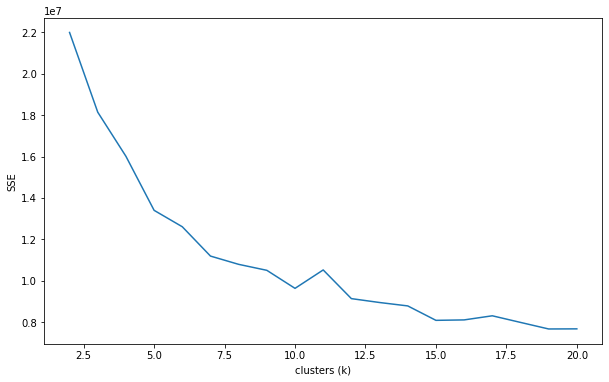

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.set_xlabel('clusters (k)')
ax.set_ylabel('SSE')
ax.plot(np.arange(2, 21), sse)

In [15]:
kmeans = KMeans(n_clusters=15, **kmeans_kwargs)
kmeans.fit(scaled_features)

KMeans(init='random', max_iter=10, n_clusters=15, random_state=42)

In [16]:
labels = kmeans.labels_.reshape(encoding.shape[:2])

In [46]:
labels.max()

14

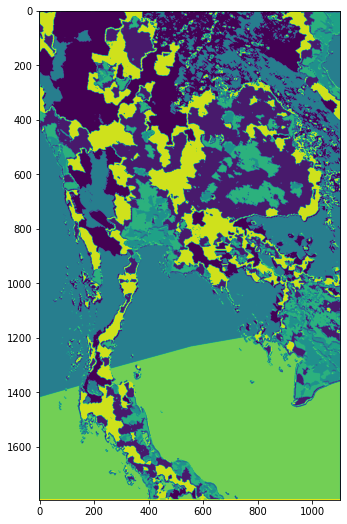

In [17]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.imshow(labels)
# fig.savefig('windowae_cluster_kmeans15')

## 4. Connectedness segmentation

In [19]:
label_pos = [np.array(np.where(labels == i)).T for i in range(15)]

In [20]:
from sklearn.cluster import DBSCAN

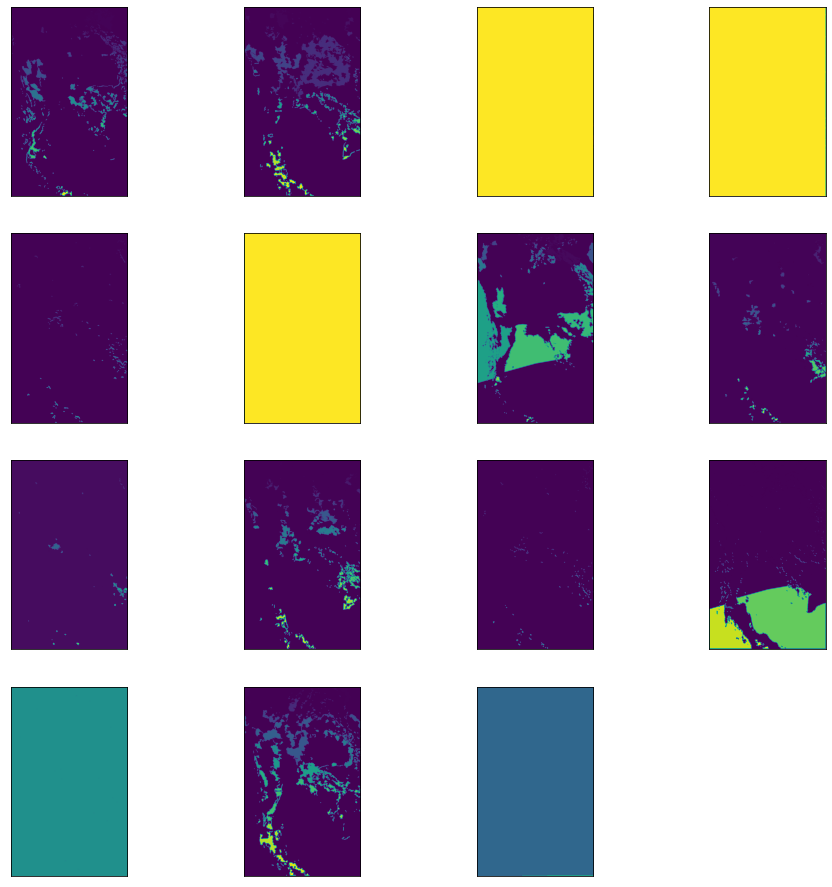

In [59]:
fig = plt.figure(figsize=(16, 16))

dbscan_labels = -np.ones_like(labels)
label_max = 0

for i in range(15):
  clustering = DBSCAN(eps=3, min_samples=16).fit(label_pos[i])
  img = np.zeros_like(labels)
  img[labels==i] = clustering.labels_
  pos_img = img[img > 0]
  dbscan_labels[img > 0] += pos_img + label_max + 1

  if pos_img.size:
    label_max += pos_img.max()

  ax = fig.add_subplot(4, 4, i+1)
  ax.imshow(img)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

In [60]:
dbscan_labels.max()

2074

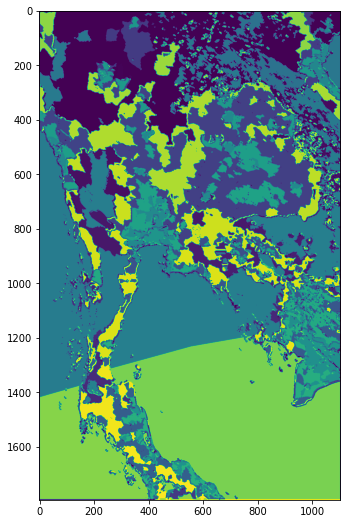

In [61]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.imshow(dbscan_labels)

Remove the colours in the sea.

In [50]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [51]:
import rasterio

In [52]:
with rasterio.open('/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time0.tif', 'r') as ds:
  time0 = ds.read()

gpw = np.zeros((time0.shape[1], time0.shape[2], 5), dtype='float')
gpw[..., 0] = time0[0]

for i in range(4):
  with rasterio.open(f'/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time{i+1}.tif', 'r') as ds:
    gpw[..., i+1] = ds.read()[0]

# gpw[np.isnan(gpw)] = 0.0  ## don't do this

In [62]:
dbscan_labels[np.isnan(gpw[..., 0])] = -1

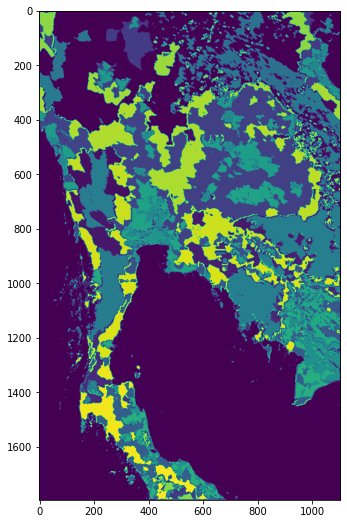

In [63]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.imshow(dbscan_labels)

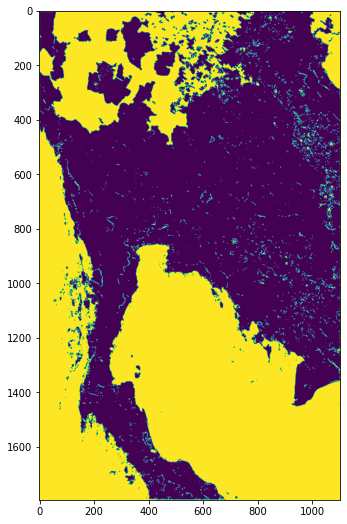

In [64]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
img = np.zeros_like(dbscan_labels)
img[dbscan_labels==-1] = 1
ax.imshow(img)

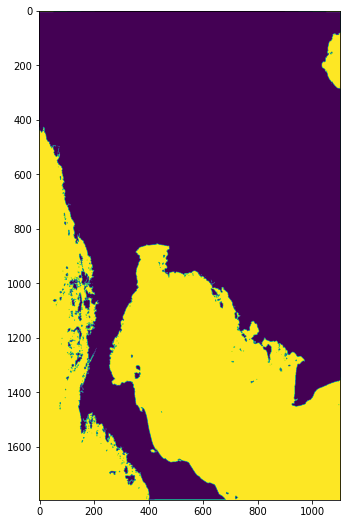

In [65]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
img = np.zeros_like(gpw[..., 0])
img[np.isnan(gpw[..., 0])] = 1
ax.imshow(img)

## 5. Population count averaging

In [101]:
np.argmax([np.sum(dbscan_labels==i) for i in range(1, dbscan_labels.max()+1)])

390

In [104]:
np.sum(dbscan_labels==391)

121920

In [105]:
gpw[dbscan_labels==391, 0]

array([67.57380676, 67.57379913, 67.57381439, ..., 39.8348732 ,
       39.83624268, 39.83761597])

In [106]:
c = 391
img = np.zeros_like(dbscan_labels)
img[dbscan_labels==c] = gpw[dbscan_labels==c, 0]

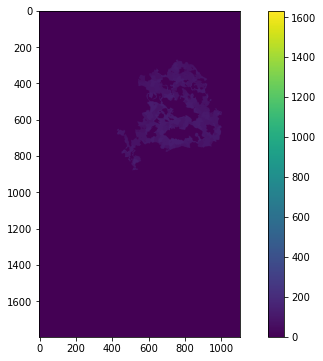

In [107]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
im = ax.imshow(img)
fig.colorbar(im, ax=ax)
fig.show()

In [112]:
popcount = np.zeros_like(dbscan_labels)

In [122]:
for i in range(1, dbscan_labels.max()+1):
  pos = dbscan_labels==i
  if pos.size:
    pop_avg = np.mean(gpw[pos, 0])
    popcount[pos] = pop_avg

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


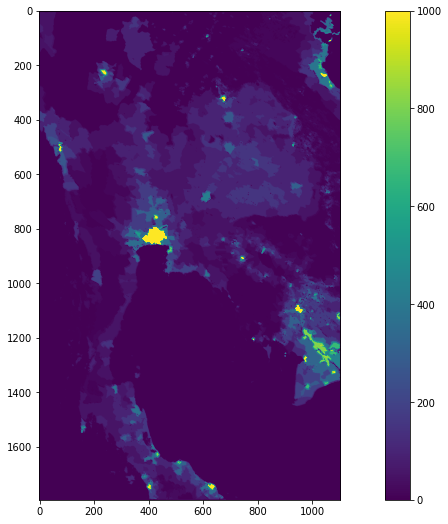

In [123]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
im = ax.imshow(popcount, vmin=0, vmax=1000)
fig.colorbar(im, ax=ax)